# Target prioritisation validation based on Open Targets score for IBD

For this MVP I just parsed  IBD-target evidence from Open Targets platform interface (this step can be improved in future).

Sources of evidence: Genetic evidence, Animal models, Expression Atlas.

We should exclude evidence sources that can be built on info about known IBD drug targets to make validation more sensible.

For **globalScore** calculation only these sources are used:
- otGeneticsPortal
- geneBurden
- eva
- uniprotLiterature (?)
- uniprotVariants (?)
- impc
- expressionAtlas

*? - means we are not sure but decided to use it for the mvp*

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
evidence_ibd_path = "data/OT-EFO_0003767-associated-targets-24_04_2024-v24_03.tsv"
evidence_ibd = pd.read_csv(evidence_ibd_path, delimiter='\t')
evaluation_set = evidence_ibd[["symbol", "globalScore"]].sort_values('globalScore', ascending=False)

In [49]:
drug_targets_path = "data/known_drug_targets_from_OT.tsv"
drug_targets = pd.read_csv(drug_targets_path, delimiter='\t')
validation_set = drug_targets[["symbol"]]

## Case 1. We dont care about validation set (ChEMBL) ranking

The simpliest metric to evaluate if we can find targets from validation set in evaluation set is "Hit Rate at K" (HR@K):

    HR@K = (Number of hits in the Top K) / (K)

Here, a "hit" means that a target from validation set is found within the top K targets of evaluation set.

HR@K shows the proportion of top K results that are "hits". Essentially, the "hit" rate will tell you what proportion of your top K decisions are correct, i.e., the symbol is present in the validation set.

In [43]:
k_values = list(range(10, 1000))

In [44]:
hit_rates = []

for k in k_values:
    # Select top K symbols based on globalScore 
    top_k = validation_set['symbol'].head(k)

    # Calculate the number of hits
    hits = validation_set[validation_set['symbol'].isin(top_k)].shape[0]

    # Calculate Hit Rate at K
    hr_at_k = hits / k

    hit_rates.append(hr_at_k)

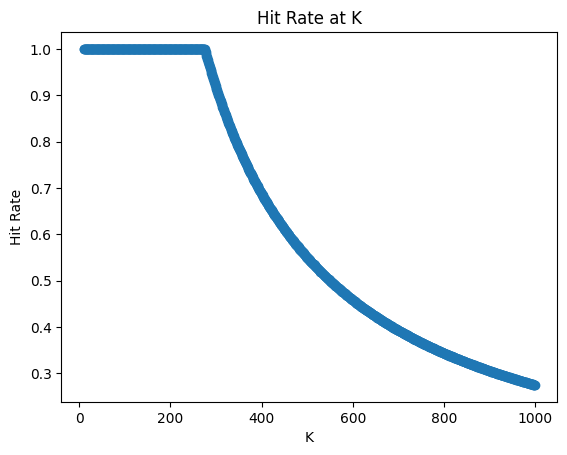

In [45]:
# Plotting hit rates
plt.plot(k_values, hit_rates, marker='o')
plt.title("Hit Rate at K")
plt.xlabel('K')
plt.ylabel('Hit Rate')
plt.show()

In [47]:
merge_evaluation = evaluation_set.merge(drug_targets, on='symbol', how='left')

In [51]:
merge_evaluation.to_csv("merge_evaluation.csv", index=False)

## Case 2. We care about ChEMBL ranking

In [7]:
# creating the ideal ranking
validation_set['rank_ideal'] = validation_set.reset_index().index

/var/folders/xs/llnz2_gn4fsfwjd4c0prr1w00000gp/T/ipykernel_1529/4089847658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['rank_ideal'] = validation_set.reset_index().index


In [11]:
# merging the dataframes
merge_df = evaluation_set.merge(validation_set, on='symbol', how='left')
merge_df['rank'] = merge_df['globalScore'].rank(method='min', ascending=False)

In [13]:
def precision_at_k(df, k):
    df_topk = df[df['rank'] <= k]
    precision = len(df_topk[df_topk['rank_ideal'] <= k]) / len(df_topk) if len(df_topk) > 0 else 0
    return precision

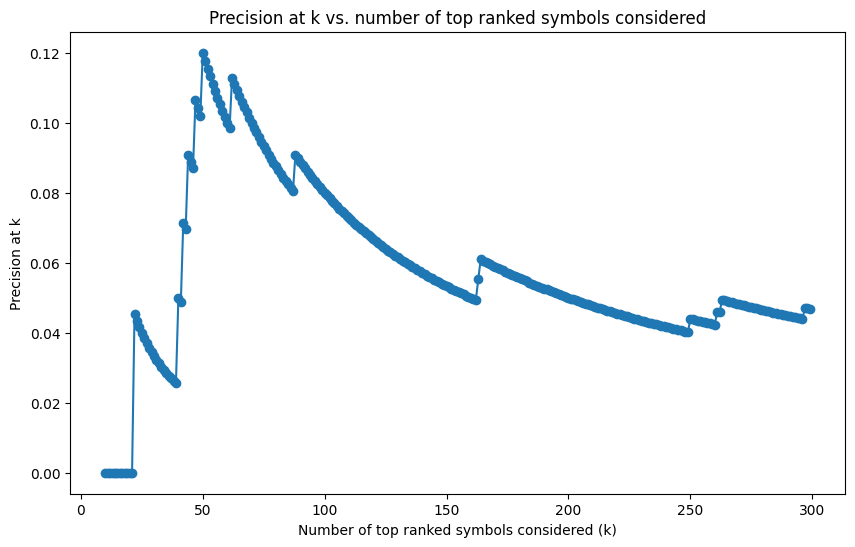

In [20]:
# set k_values as a continuous list from 10 to 1000
k_values = list(range(10, 300))

# calculate precision for each k value and store the results in a data frame
results = pd.DataFrame({
 'k': k_values,
 'precision': [precision_at_k(merge_df, k) for k in k_values]
})

# plot the results
plt.figure(figsize=(10,6))
plt.plot(results['k'], results['precision'], marker='o')
plt.title('Precision at k vs. number of top ranked symbols considered')
plt.xlabel('Number of top ranked symbols considered (k)')
plt.ylabel('Precision')
plt.show()